In [1]:
from __future__ import division
import numpy as np
from numpy.random import choice, normal, multivariate_normal
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
%matplotlib inline

In [2]:
import csv
def read_data(file_path):
    # The read-in data should be a N*W matrix,
    # where N is the length of the time sequences,
    # W is the number of sensors/data features
    i = 0
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter = ',')
        for line in reader:
            line = np.array(line, dtype = 'float') # str2float
            if i == 0:
                data = line
            else:
                data = np.vstack((data, line))
            i += 1
    return data

<function matplotlib.pyplot.show>

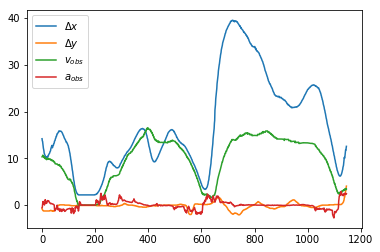

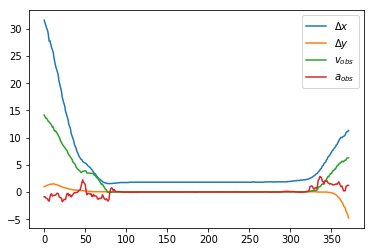

In [3]:
# data_path = "four_scores.csv"
# data_path = "Brightness_features.csv"
# data_path = "obs_data_16d.csv"
# data_path = "ego_data_20d.csv"
data_path = "train_data.csv"
data = read_data(data_path)
data = data[:,3:7]#data[15500:16500,0:1] #data[8000:8500,[0,9]]
n,d = data.shape
plt.figure(1)
plt.plot(range(data.shape[0]),data)
plt.legend([r'$\Delta x$', r'$\Delta y$', r'$\Delta v$', r'$\Delta a$'])
plt.savefig('segment_1.png',dpi=200)
plt.show
# normalize
# for i in range(d):
#     if np.std(data[:,i]) != 0:
#         data[:,i] = (data[:,i]-np.mean(data[:,i]))/np.std(data[:,i])
#     else:
#         data[:,i]    
# plt.figure(2)
# plt.plot(range(data.shape[0]),data)
# plt.show

# load test data
data_path = "test_data.csv"
test_data = read_data(data_path)
test_data = test_data[:,3:7]#data[15500:16500,0:1] #data[8000:8500,[0,9]]
n,d = test_data.shape
plt.figure(2)
plt.plot(range(test_data.shape[0]),test_data)
plt.legend([r'$\Delta x$', r'$\Delta y$', r'$\Delta v$', r'$\Delta a$'])
plt.savefig('segment_2.png',dpi=200)
plt.show


In [135]:
class HMM():
    def __init__(self,data,K=10,model='Gaussian',kmeans_init=False):
        self.K = K # hmm state space size
        self.n,self.d = data.shape
        self.state_list = np.arange(self.K)
        self.data = data # training data
        
        # initialize parameters
        self.pi0 = np.ones(self.K)*1/self.K # first state prior, a (K,) array
        
        if kmeans_init:
            self.state = kmeans2(self.data, self.K)[1]
        else:
            self.state = choice(self.K,self.n)
        self.model = model # observation model
        if self.model == 'Gaussian' or 'GMM':
            # compute parameter for each cluster
            self.mu = []
            self.sigma = []
            for k in range(self.K):
                idx = np.where(self.state==k)[0] # multi variable
                nc = len(idx)
                if nc:# multi variable
                    cluster = np.reshape(self.data[idx,:],(nc,self.d))
                    self.mu.append(np.mean(cluster,0)) # multi variable
                    if nc > 1:
                        self.sigma.append(np.cov(cluster,rowvar=False)) # multi variable
                    else:
                        self.sigma.append(np.eye(self.d))
                else:
                    cluster = []
                    self.mu.append(multivariate_normal(np.zeros(self.d), np.eye(self.d))) # multi variable
                    self.sigma.append(np.eye(self.d)) # multi variable
        self.log_like_matrix = np.zeros([self.n, self.K])
        # transition model 
        self.N = np.zeros((self.K, self.K))
        for n in range(1, self.n):
            self.N[self.state[n-1], self.state[n]] += 1
        self.A = (self.N.T/(np.sum(self.N, axis=1)+1e-7)).T
        
        self.test_states = []
        self.test_trans_list = []
        
        self.pred_hidden_state_list = []
        if self.model == 'GMM':
            self.omega = np.ones(self.K) * 1/self.K
            
    def train(self, num_iter,converge_thresh):
        prevQ = -1e20
        i = 0
        while i < num_iter:
            self.log_like_matrix = self.log_likelihood_matrix(self.data)

            self.alpha,self.beta = self.forward_backward_algorithm()

            self.E_step()

            Q = self.check_log_likelihood()

            self.M_step()

            if Q < prevQ:
                print('warning: the log-likelihood is decreasing')
            print ('log-likelihood: ', Q)
            if Q - prevQ < converge_thresh:
                print('THe log-likelihood converges')
                return
            prevQ = Q
            i += 1
    
    def test(self,test_data):
        log_like_matrix = self.log_likelihood_matrix(test_data)
        self.test_states =  np.argmax(log_like_matrix,axis=1)
        self.test_trans_list = [] #np.zeros(len(self.test_states))
        for n in range(1,len(self.test_states)):
            p_trans = self.A[self.test_states[n-1], self.test_states[n]]
            self.test_trans_list = np.append(self.test_trans_list, p_trans)
            print ("p_trans", p_trans)
            
    def predict(self, observable_data, pred_step=20):
        '''
        Predict the future data based on the initial observation.
        Observable data: {x, y, yaw_angle, velocity, d_l, d_r}
        Predict data: {acceleration, yaw_rate}
        '''
        num_observable = 4
        num_hidden = 2
        pred_start = 10
        
        observable_matrix = self.log_likelihood_matrix(observable_data)
        # init beta
        if self.model == 'GMM':
            beta = self.omega * observable_matrix[0,:]/np.sum(self.omega * observable_matrix[0,:])
        else:
            beta = np.ones(self.K) * 1/self.K # init a beta
            
        for t in range(observable_data.shape[0]):
            beta_den = beta * np.sum(self.A, axis=0) * observable_matrix[t,:]
            beta_num = np.sum(beta_den)#beta * np.sum((np.sum(self.A, axis=0) * observable_matrix[t,:]))
            beta = beta_den/beta_num
            pred_hidden_state = np.zeros(num_hidden) 
            if t > pred_start:
                for k in range(self.K):
                    diff = observable_data[t] - self.mu[k][0:num_observable]
                    tmp_mu = self.mu[k][num_observable:num_observable+num_hidden]
                    tmp_sigma_1 = self.sigma[k][0:num_observable,num_observable:num_observable+num_hidden]
                    tmp_sigma_2 = self.sigma[k][0:num_observable, 0:num_observable]
                    
                    pred_hidden_state += beta[k] * (tmp_mu + np.dot(np.dot(tmp_sigma_1.T, np.linalg.pinv(tmp_sigma_2)),diff))
            
                self.pred_hidden_state_list.append(pred_hidden_state)
        
#         log_like_init = self.log_likelihood_matrix(np.reshape(test_data[0,:], (1,self.d)))
#         init_state =  np.argmax(log_like_init)
        
#         for n in range(1,tets_data.shape[0]):
#             data = test_data[n,:]
#             *self.A[init_state,:]
        
    def E_step(self):
        pX = np.reshape(np.sum(self.alpha*self.beta,axis=1),(self.n,1)) 
        
        self.gamma = self.alpha*self.beta/pX # n * k matrix
        
        self.xi = np.zeros([self.n-1, self.K, self.K]) # n-1 * k * k matrix
        for n in range(1,self.n):
            
            xi_num = (np.dot(np.reshape(self.alpha[n-1,:],(self.K,1)),
                             np.reshape(np.exp(self.log_like_matrix[n,:]) * self.beta[n,:], (1,self.K))) *\
                                  self.A)
            xi_den = np.sum(np.sum(xi_num,axis=1))
            self.xi[n-1,:,:] = xi_num/xi_den
        '''
        Figure out the difference using MGD and GMM model in E-step
        '''
        
    def M_step(self):
        # update first state prior
        self.pi0 = self.gamma[0,:]/np.sum(self.gamma[0,:])
        
        # update transition model
        A_num = np.sum(self.xi, axis=0)
        A_den = np.reshape(np.sum(A_num,axis=1),(self.K,1))
        self.A = A_num/A_den
        
        # update emission model
        if self.model == 'Gaussian':
            for k in range(self.K):
                mu_num = np.sum(np.reshape(self.gamma[:,k],(self.n,1)) * self.data, axis=0) # (d,) matrix
                mu_den = np.sum(self.gamma[:,k])# scalar
                self.mu[k] = mu_num/mu_den

                sigma_num = np.dot((self.data-self.mu[k]).T, np.reshape(self.gamma[:,k],(self.n,1))*(self.data-self.mu[k]))
                sigma_den = mu_den
                self.sigma[k] = sigma_num/sigma_den
        if self.model == 'GMM':
#             p_num = self.omega * self.log_like_matrix # n * K matrix
#             P_den = np.reshape(np.sum(self.omega * self.log_like_matrix, axis=1),(self.n,1)) # n * 1 array
#             self.P = P_num/P_den # n * K matrix
            self.P = self.omega * self.gamma / np.reshape(np.sum(self.omega * self.gamma, axis=1), (self.n,1))
            self.omega = np.sum(self.P, axis=0)/self.n
            for  k in range(self.K):
                self.mu[k] = np.sum(self.data * np.reshape(self.P[:,k], (self.n,1)), axis=0) / np.sum(self.P[:,k]) # (d,) array 
                self.sigma[k] = np.dot((self.data - self.mu[k]).T, 
                                    np.reshape(self.P[:,k], (self.n,1))*(self.data-self.mu[k]))/ np.sum(self.P[:,k])
                
            
    def forward_backward_algorithm(self):
        # forward
        alpha = np.zeros((self.n, self.K))
        alpha[0, :] = self.pi0*np.exp(self.log_like_matrix[0,:])#1
        for t in range(1, self.n):
#             if self.model == 'Gaussian':
            alpha[t,:] = (self.A.T.dot(alpha[t-1,:])) * np.exp(self.log_like_matrix[t,:])
#             if self.model == 'GMM':
                
#                 alpha[t,:] = (self.A.T.dot(alpha[t-1,:])) * np.exp(self.P[t,:])
            alpha[t, :] /= np.max(alpha[t, :])
        # backward
        beta = np.zeros((self.n, self.K))
        beta[-1, :] = 1
        for t in range(self.n - 1, 0, -1):
#             if self.model == 'Gaussian':
            beta[t-1, :] = self.A.dot(beta[t, :] * np.exp(self.log_like_matrix[t,:]))
#             if self.model == 'GMM':
#                 beta[t-1, :] = self.A.dot(beta[t, :] * np.exp(self.P[t,:]))
            beta[t-1, :] /= np.max(beta[t-1, :])            
        return alpha, beta
    
    def log_likelihood_matrix(self,data):
        '''
        Likelihood matrix of all observations, each row is the likelihood of one data given all possible states.
        Output: log-likelihood matrix with size self.n*K
        '''
#         if self.model == 'Gaussian':
        N,d = data.shape
        log_like_matrix = np.zeros([N,self.K])
        for n in range(N):
            for k in range(self.K):
                diff = data[n,:]-self.mu[k][0:d]
                sigma = self.sigma[k][0:d,0:d]
                log_like_matrix[n,k] = (-1/2) * np.dot(np.dot(diff, np.linalg.pinv(sigma)), diff.T) - np.log(np.sqrt(np.linalg.det(2*np.pi*sigma)))
#         if self.mode == 'GMM':
            
        return log_like_matrix

    def check_log_likelihood(self):
        idx = np.where(self.pi0!=0)[0]
        term1 = np.dot(self.gamma[0,idx],np.log(self.pi0[idx]))
        term2 = 0
        idx = np.where(hmm.A!=0)
        for n in range(1,self.n):
            xi = self.xi[n-1,:,:]
            term2 += np.sum(np.sum(xi[idx]*np.log(self.A[idx])))
        term3 = np.sum(np.sum(self.gamma * self.log_like_matrix))
        
        print (term1)
        print (term2)
        print (term3)
        return term1+term2+term3

In [136]:
# new_data_try = np.hstack([data,ego_car_list[:,0:3]])
hmm = HMM(train_data,model='GMM')

In [137]:
num_iter = 100
converge_thresh = 1e-5
hmm.train(num_iter, converge_thresh)

-2.30258509299
-2589.24875061
665.250027874
log-likelihood:  -1926.30130782
-1.78250512335
-2359.73594348
1806.4192929
log-likelihood:  -555.099155701
-1.14334358918
-1723.99344024
3152.59024472
log-likelihood:  1427.45346088
-0.0277562865581
-904.477882466
4380.80335832
log-likelihood:  3476.29771957
-1.90871155361e-07
-410.712859975
5752.54766644
log-likelihood:  5341.83480627
-7.29418576714e-14
-279.861660327
6466.85846738
log-likelihood:  6186.99680706
-5.64874074708e-26
-253.711442279
6756.43154605
log-likelihood:  6502.72010377
-1.79539796887e-32
-242.837841606
6823.51785475
log-likelihood:  6580.68001314
-8.12093518424e-39
-241.955571573
6863.58540794
log-likelihood:  6621.62983637
-3.68756223255e-45
-240.471332158
6877.21911717
log-likelihood:  6636.74778501
-1.73415416864e-51
-240.419859071
6877.83152064
log-likelihood:  6637.41166156
-8.37314223882e-58
-240.364222069
6878.11061896
log-likelihood:  6637.74639689
-4.09971790274e-64
-240.257471679
6878.69488727
log-likelihood:  

<function matplotlib.pyplot.show>

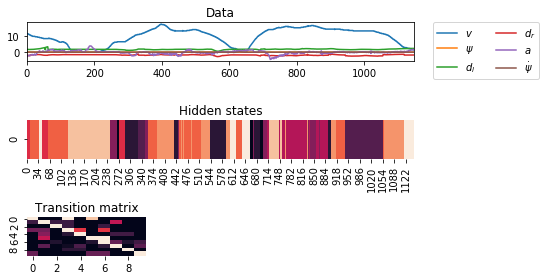

In [138]:
states = np.argmax(hmm.log_like_matrix,axis=1)
plt.figure(2)
ax1 = plt.subplot(311)
plt.plot(range(hmm.n),train_data)
plt.xlim([0,hmm.n])
ax1.set_title("Data")
# lgd = plt.legend([r'$\Delta x$', r'$\Delta y$', r'$v_{obs}$', r'$a_{obs}$'],bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
# lgd = plt.legend([r'$\Delta x$', 
#                   r'$\Delta y$', 
#                   r'$\Delta v$', 
#                   r'$\Delta a$'
# #                   r'$v_{ego}$',
# #                   r'$a_{ego}$',
# #                   r'$\psi_{ego}$'
#                  ],bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
lgd = plt.legend([r'$v$', 
                  r'$\psi$', 
                  r'$d_l$', 
                  r'$d_r$',
                  r'$a$',
                  r'$\dot{\psi}$'
                 ],bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)

ax2 = plt.subplot(312)
sns.heatmap(np.reshape(states,(1,hmm.n)), ax=ax2, cbar=False)
ax2.set_title("Hidden states")

ax3 = plt.subplot(337)
sns.heatmap(hmm.A, ax=ax3,vmin=0, vmax=0.05, cbar=False)
ax3.set_title("Transition matrix")
# plt.subplot(133)
# plt
plt.tight_layout(h_pad=1.0)
# plt.savefig('example_1_result.png', bbox_extra_artists=(lgd,),bbox_inches='tight', dpi=200)
plt.show

array([ 0.04998472,  0.11030588,  0.14536907,  0.14389007,  0.08831762,
        0.03223942,  0.09171638,  0.07402121,  0.20459219,  0.05956345])

p_trans 0.952641890648
p_trans 0.952641890648
p_trans 0.952641890648
p_trans 0.952641890648
p_trans 1.05099442716e-73
p_trans 0.903732455448
p_trans 0.903732455448
p_trans 0.903732455448
p_trans 0.903732455448
p_trans 0.0722006875222
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans 0.965193852466
p_trans

[  4   9  47  49  73  74  75 145 342 348 349 350 356]


array([  1.05099443e-73,   7.22006875e-02,   2.31288411e-33,
         1.54197692e-12,   2.31288411e-33,   1.54197692e-12,
         2.31288411e-33,   1.54197692e-12,   2.31288411e-33,
         1.54197692e-12,   2.31288411e-33,   1.54197692e-12,
         2.31288411e-33])

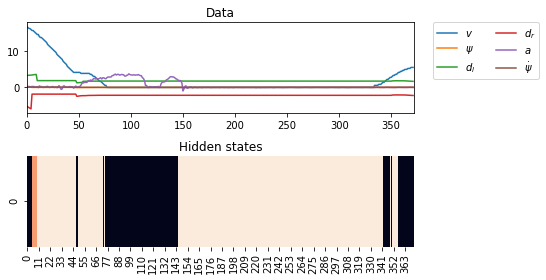

In [139]:
# new_test_try = np.hstack([test_data,ego_car_list[:,0:3]])
hmm.test(test_data)
plt.figure(3)
ax1 = plt.subplot(211)
plt.plot(range(test_data.shape[0]),test_data)
plt.xlim([0,test_data.shape[0]])
ax1.set_title("Data")
# lgd = plt.legend([r'$\Delta x$', 
#                   r'$\Delta y$', 
#                   r'$\Delta v$', 
#                   r'$\Delta a$'
# #                   r'$v_{ego}$',
# #                   r'$a_{ego}$',
# #                   r'$\psi_{ego}$'
#                  ],bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
lgd = plt.legend([r'$v$', 
                  r'$\psi$', 
                  r'$d_l$', 
                  r'$d_r$',
                  r'$a$',
                  r'$\dot{\psi}$'
                 ],bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
ax2 = plt.subplot(212)
sns.heatmap(np.reshape(hmm.test_states,(1,test_data.shape[0])), ax=ax2, cbar=False)
ax2.set_title("Hidden states")

plt.tight_layout(h_pad=1.0)
plt.savefig('example_2_result.png', bbox_extra_artists=(lgd,),bbox_inches='tight', dpi=200)
plt.show

state_change_idx = np.where(np.array(hmm.test_trans_list)<0.9)[0]
print(state_change_idx)
np.array(hmm.test_trans_list)[state_change_idx]

In [140]:
hmm.predict(test_data[:,0:4], 20)


<function matplotlib.pyplot.show>

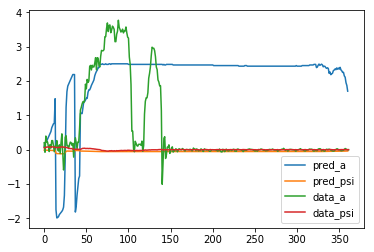

In [142]:
prediction = np.array(hmm.pred_hidden_state_list)
plt.plot(prediction)
plt.plot(test_data[10:,[4,5]])
plt.legend(['pred_a','pred_psi','data_a','data_psi'])
plt.show


In [20]:
'''
Load the MRM data
'''
data_name='MRM_result.pkl'
MRM_results = pkl.load(open(data_name, 'rb'))
'''
load one example segment of the first channel obstacle data
'''
exp_data_path = "test_data.csv"
exp_data = read_data(exp_data_path)
exp_data[:,0] += 1149
'''
load the ego car data
'''
ego_data_path = "ego_data_24d.csv"
ego_data = read_data(ego_data_path)
ego_lane = ego_data[:,[18,19,15,16,20,21,22,23]]
ego_data = ego_data[:,[0,17,18,19,9,14]] # x_dot_ego, psi_T_0, left_dist, right_dist, accel_x, r_rate,

# other wise the left and right dist is 1.88 and -1.88


In [21]:
num_actions = 3
ego_lane_exp_list = []
ego_car_list = []
ego_prob_list = []
obs_prob_list = []
violation_prob_list = []
for i, MRM in enumerate(MRM_results):
    if MRM['frame_id'] < 1150: # skip parking lot
        continue
    if MRM['frame_id']+1 in exp_data[:,0]:
        # read ego car data
        ego_lane_exp = ego_lane[MRM['frame_id'],:]
        ego_car = ego_data[MRM['frame_id'],:]
        matched_obs_idx = np.where(MRM['obs_id'] == exp_data[0,1])[0]
        ego_action_prob = np.reshape(MRM['ego_probs'], (num_actions,))
        obs_action_prob = np.reshape(MRM['obs_probs'][:,matched_obs_idx], (num_actions,))#matched_obs_idx*3:(matched_obs_idx+1)*3
        violation_prob = np.reshape(MRM['violation_prob'][:,matched_obs_idx,:], (num_actions, num_actions))
        
        # save to list
        ego_lane_exp_list.append(ego_lane_exp)
        ego_car_list.append(ego_car)
        ego_prob_list.append(ego_action_prob)
        obs_prob_list.append(obs_action_prob)
        violation_prob_list.append(violation_prob)
        
ego_lane_exp_list = np.array(ego_lane_exp_list)
ego_car_list = np.array(ego_car_list)
ego_prob_list = np.array(ego_prob_list)        
obs_prob_list = np.array(obs_prob_list)
violation_prob_list = np.array(violation_prob_list)

In [47]:
a = np.ones([5,3])
a[1,0:2]

array([ 1.,  1.])

In [14]:

'''
Use kinematics to estimate distances from obs cars to their lane edges and obs cars' yaw angle and rate
'''
x = exp_data[:,3]
y = exp_data[:,4]
left_at_obs = -ego_lane_exp_list[:,6] * x**3 - ego_lane_exp_list[:,4] * x**2 - ego_lane_exp_list[:,2] * x + ego_lane_exp_list[:,0]
right_at_obs = -ego_lane_exp_list[:,7] * x**3 - ego_lane_exp_list[:,5] * x**2 - ego_lane_exp_list[:,3] * x + ego_lane_exp_list[:,1]
center_at_obs = (left_at_obs + right_at_obs)/2

obs_left_dist = np.ones(exp_data.shape[0]) * 1.88
obs_right_dist = np.ones(exp_data.shape[0]) * -1.88

dist_to_left = y-left_at_obs
dist_to_right = y-right_at_obs
# when the obs car is within ego lane
within_ego_lane_idx = (dist_to_left < 0) & (dist_to_right > 0)
obs_left_dist[within_ego_lane_idx] = -dist_to_left[within_ego_lane_idx]
obs_right_dist[within_ego_lane_idx] = -dist_to_right[within_ego_lane_idx]
# when the obs car is within the left/right next lanes
within_left_lane_idx = (dist_to_left > 0) & (dist_to_left < 3.7)
within_right_lane_idx = (dist_to_right < 0) & (dist_to_right > -3.7)
obs_right_dist[within_left_lane_idx] = -dist_to_left[within_left_lane_idx]
obs_left_dist[within_left_lane_idx] = 3.7 -dist_to_left[within_left_lane_idx]
obs_right_dist[within_right_lane_idx] = -dist_to_right[within_right_lane_idx]-3.7
obs_left_dist[within_right_lane_idx] = -dist_to_right[within_right_lane_idx]

'''
Use kinematics to estimate obs car yaw angle;
assume the heading angle of obs car is parallel to its lane edge.
'''
heading_at_obs = ((-3*ego_lane_exp_list[:,6] * x**2 - 2*ego_lane_exp_list[:,4] * x - ego_lane_exp_list[:,2]) + 
                 (-3*ego_lane_exp_list[:,7] * x**2 - 2*ego_lane_exp_list[:,5] * x - ego_lane_exp_list[:,3]))/2

psi_dot = np.zeros(exp_data.shape[0])
psi_dot[1:exp_data.shape[0]] = heading_at_obs[1:exp_data.shape[0]]-heading_at_obs[0:exp_data.shape[0]-1]



In [5]:
# print(ego_lane_exp_list[0:50,0])
# print(ego_lane_exp_list[0:50,1])
# print(left_at_obs[0:50])
# print(right_at_obs[0:50])
# print(dist_to_left[0:50])
# print(dist_to_right[0:50])
# print(obs_left_dist[1100:-1])
# print(obs_right_dist[1100:-1])


[[ 0.37049304  0.48727663  0.08956849]
 [ 0.13063079  0.77840375  0.42856613]
 [ 0.24579774  0.8063904   0.4388607 ]
 [ 0.70256156  0.73732384  0.95859231]
 [ 0.16382847  0.14731958  0.77359607]]
[ 0.12377799  0.04667647  0.15624804]
[[ 0.04585888  0.02274435  0.0139949 ]
 [ 0.01616922  0.03633314  0.06696262]
 [ 0.03042435  0.03763945  0.06857112]
 [ 0.08696166  0.03441567  0.14977817]
 [ 0.02027836  0.00687636  0.12087287]]
[ 0.08259813  0.11946497  0.13663493  0.2711555   0.14802759]
[[ 0.55520483  0.27536155  0.16943362]
 [ 0.13534693  0.30413213  0.56052094]
 [ 0.22266891  0.27547461  0.50185648]
 [ 0.32070771  0.12692227  0.55237003]
 [ 0.1369904   0.04645322  0.81655638]]


In [7]:
0.02274435/ 0.08259813

0.27536156084889574

<function matplotlib.pyplot.show>

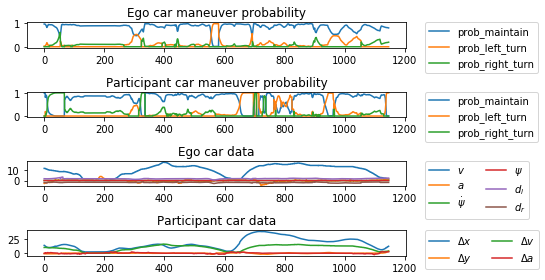

In [12]:
plt.figure(1)
ax1 = plt.subplot(411)
ax1.plot(range(ego_prob_list.shape[0]),ego_prob_list)
ax1.legend(['prob_maintain','prob_left_turn', 'prob_right_turn'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.set_title('Ego car maneuver probability')

ax2 = plt.subplot(412)
ax2.plot(range(obs_prob_list.shape[0]),obs_prob_list)
ax2.legend(['prob_maintain','prob_left_turn', 'prob_right_turn'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.set_title('Participant car maneuver probability')

ax3 = plt.subplot(413)
ax3.plot(range(ego_car_list.shape[0]),ego_car_list)
ax3.legend([r'$v$', r'$a$', r'$\dot{\psi}$', r'$\psi$', r'$d_l$', r'$d_r$'], bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
ax3.set_title('Ego car data')

ax4 = plt.subplot(414)
ax4.plot(range(exp_data.shape[0]),exp_data[:,3:7])
lgd = ax4.legend([r'$\Delta x$', r'$\Delta y$', r'$\Delta v}$', r'$\Delta a$'], bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
ax4.set_title('Participant car data')

plt.tight_layout()
plt.savefig('action_data.png', bbox_extra_artists=(lgd,),bbox_inches='tight', dpi=200)
plt.show